In [1]:
# 0. Set Up Environment
!pip install transformers datasets evaluate jiwer accelerate torch torchvision torchaudio matplotlib tqdm scikit-learn
!pip install evaluate
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 75.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [2]:
import kagglehub
import os
import re
from PIL import Image, UnidentifiedImageError
import torch
from torch.utils.data import Dataset
from transformers import (
    TrOCRProcessor,
    VisionEncoderDecoderModel,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from evaluate import load as load_evaluate_metric
import numpy as np
import glob
import pandas as pd

In [3]:
imamdigmi_indonesian_plate_number_path = kagglehub.dataset_download('imamdigmi/indonesian-plate-number')
firqaaa_indonesian_vehicle_plate_numbers_path = kagglehub.dataset_download('firqaaa/indonesian-vehicle-plate-numbers')
juanthomaswijaya_indonesian_license_plate_dataset_path = kagglehub.dataset_download('juanthomaswijaya/indonesian-license-plate-dataset')

print('Data source import complete.')

100%|██████████| 157M/157M [00:10<00:00, 16.3MB/s]

Extracting files...


100%|██████████| 179M/179M [00:09<00:00, 20.6MB/s]

Extracting files...


100%|██████████| 1.92G/1.92G [01:31<00:00, 22.5MB/s]

Extracting files...


Data source import complete.


In [4]:
# 1. Konfigurasi Dasar dan Path

# Path spesifik di Kaggle setelah diunduh
KAGGLE_SPECIFIC_PATH = juanthomaswijaya_indonesian_license_plate_dataset_path + "/Indonesian License Plate Dataset/"
# Default path jika tidak di Kaggle atau path spesifik tidak ditemukan
DEFAULT_DATASET_PATH = "./Indonesian_License_Plate_Dataset/" # Ganti jika dataset Anda di tempat lain

DATASET_BASE_DIR = DEFAULT_DATASET_PATH # Default awal

if os.path.exists(KAGGLE_SPECIFIC_PATH):
    DATASET_BASE_DIR = KAGGLE_SPECIFIC_PATH
    print(f"Menggunakan path dataset Kaggle: {DATASET_BASE_DIR}")
elif os.path.exists(DEFAULT_DATASET_PATH):
    DATASET_BASE_DIR = DEFAULT_DATASET_PATH
    print(f"Menggunakan path dataset lokal: {DATASET_BASE_DIR}")
else:
    print(f"ERROR: Path dataset tidak ditemukan di Kaggle ('{KAGGLE_SPECIFIC_PATH}') atau lokal ('{DEFAULT_DATASET_PATH}').")
    print("Pastikan DATASET_BASE_DIR diatur dengan benar atau dataset ada di path yang diharapkan.")
    # Remove the exit() call to allow subsequent cells to run,
    # while still informing the user of the issue.
    # exit()


TRAIN_IMAGE_DIR = os.path.join(DATASET_BASE_DIR, "images/train/")
TRAIN_LABEL_DIR = os.path.join(DATASET_BASE_DIR, "labelswithLP/train/") # Sesuaikan jika nama folder label berbeda

VAL_IMAGE_DIR = os.path.join(DATASET_BASE_DIR, "images/val/")
VAL_LABEL_DIR = os.path.join(DATASET_BASE_DIR, "labelswithLP/val/") # Sesuaikan

TEST_IMAGE_DIR = os.path.join(DATASET_BASE_DIR, "images/test/")
TEST_LABEL_DIR = os.path.join(DATASET_BASE_DIR, "labelswithLP/test/") # Sesuaikan

MODEL_NAME = "microsoft/trocr-base-stage1"
OUTPUT_DIR = "./trocr_finetuned_plat_nomor_final_v2" # Output di direktori kerja
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hyperparameters
NUM_TRAIN_EPOCHS = 5
PER_DEVICE_TRAIN_BATCH_SIZE = 8
PER_DEVICE_EVAL_BATCH_SIZE = 8
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 0.01
LOGGING_STEPS = 50
EVAL_STEPS = 200  # Samakan dengan save_steps jika load_best_model_at_end=True ingin dicoba lagi
SAVE_STEPS = 200  # Samakan dengan eval_steps
RANDOM_SEED = 42
MAX_TARGET_LENGTH = 15 # Plat nomor Indonesia (misal, B 1234 XYZ -> 8-9 char + spasi), beri buffer

torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

Menggunakan path dataset Kaggle: /root/.cache/kagglehub/datasets/juanthomaswijaya/indonesian-license-plate-dataset/versions/1/Indonesian License Plate Dataset/


In [5]:
# 2. Fungsi untuk memuat data dari struktur dataset baru Anda
def get_image_paths_and_labels_from_txt(image_dir, label_dir):
    image_paths = []
    labels = []

    if not os.path.isdir(image_dir):
        print(f"Peringatan: Direktori gambar '{image_dir}' tidak ditemukan.")
        return image_paths, labels
    if not os.path.isdir(label_dir):
        print(f"Peringatan: Direktori label '{label_dir}' tidak ditemukan.")
        return image_paths, labels

    img_extensions = ['*.jpg', '*.jpeg', '*.png']
    image_files_found = []
    for ext in img_extensions:
        image_files_found.extend(glob.glob(os.path.join(image_dir, ext)))

    print(f"Ditemukan {len(image_files_found)} file gambar di {image_dir}")

    for img_path in tqdm(image_files_found, desc=f"Memproses label di {label_dir}"):
        base_filename = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(label_dir, base_filename + ".txt")

        if os.path.exists(label_path):
            try:
                with open(label_path, 'r', encoding='utf-8') as f: # Tambahkan encoding
                    found_plate_in_file = False
                    for line_num, line in enumerate(f):
                        parts = line.strip().split()
                        if len(parts) >= 6:
                            # Asumsi class_id untuk plat nomor adalah 0 atau yang paling relevan
                            # Jika ada class_id spesifik untuk plat, sesuaikan di sini
                            class_id = parts[0]
                            # Anda mungkin perlu memfilter berdasarkan class_id jika ada objek lain
                            # if class_id != "0": # Contoh jika class_id plat adalah "0"
                            #     continue

                            plate_number_parts = parts[5:] # Ambil semua bagian sisa sebagai plat nomor
                            plate_number = "".join(plate_number_parts).upper() # Gabungkan dan uppercase

                            # Validasi sederhana (bisa diperketat)
                            if re.match(r'^[A-Z0-9]+$', plate_number) and 3 <= len(plate_number) <= MAX_TARGET_LENGTH -2:
                                image_paths.append(img_path)
                                labels.append(plate_number)
                                found_plate_in_file = True
                                break # Ambil plat pertama yang valid dari file ini
                            # else:
                                # print(f"Format plat nomor tidak valid atau terlalu panjang di {label_path} baris {line_num+1}: '{plate_number}'")
                    # if not found_plate_in_file:
                        # print(f"Tidak ada plat nomor valid ditemukan di: {label_path}")
            except Exception as e:
                # print(f"Error membaca file label {label_path}: {e}")
                pass
        # else:
            # print(f"File label tidak ditemukan untuk: {img_path} (dicari: {label_path})")

    return image_paths, labels

In [6]:
# 3. Kelas Dataset
class PlateNumberDataset(Dataset):
    def __init__(self, image_paths, labels, processor, max_target_length=MAX_TARGET_LENGTH):
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = str(self.labels[idx])

        try:
            image = Image.open(image_path).convert("RGB")
        except FileNotFoundError:
            # print(f"File tidak ditemukan: {image_path}")
            if idx > 0: return self.__getitem__(idx - 1)
            raise
        except UnidentifiedImageError:
            print(f"Warning: Gagal membuka gambar {image_path}. Mungkin korup. Mencoba sampel berikutnya.")
            if self.__len__() <= 1: # Jika hanya 1 sampel atau kurang dan itu korup
                 raise UnidentifiedImageError(f"Critical: Cannot open image {image_path} and no other valid samples.")
            # Coba ambil sampel acak lain untuk menghindari loop tak terbatas jika banyak file korup berurutan
            import random
            next_idx = random.choice([i for i in range(self.__len__()) if i != idx])
            return self.__getitem__(next_idx)


        pixel_values = self.processor(images=image, return_tensors="pt").pixel_values.squeeze()

        labels_dict = self.processor.tokenizer(label,
                                             padding="max_length",
                                             max_length=self.max_target_length,
                                             truncation=True,
                                             return_tensors="pt")
        labels_tensor = labels_dict.input_ids.squeeze()
        labels_tensor[labels_tensor == self.processor.tokenizer.pad_token_id] = -100

        return {"pixel_values": pixel_values, "labels": labels_tensor}

In [7]:
# 4. Inisialisasi Processor dan Model
print(f"Memuat processor dan model dari: {MODEL_NAME}")
try:
    processor = TrOCRProcessor.from_pretrained(MODEL_NAME)
    model = VisionEncoderDecoderModel.from_pretrained(MODEL_NAME)
except Exception as e:
    print(f"Gagal memuat model atau processor: {e}")
    exit()

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id
# Sesuaikan max_length untuk generasi, harus >= max_target_length saat tokenisasi
model.config.max_length = MAX_TARGET_LENGTH # Untuk generate()
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4
print("Konfigurasi model telah diatur.")

Memuat processor dan model dari: microsoft/trocr-base-stage1


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Konfigurasi model telah diatur.


In [8]:
# 5. Menyiapkan Dataset
print("Menyiapkan dataset...")
train_image_paths, train_labels = get_image_paths_and_labels_from_txt(TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR)
val_image_paths, val_labels = get_image_paths_and_labels_from_txt(VAL_IMAGE_DIR, VAL_LABEL_DIR)
test_image_paths, test_labels = get_image_paths_and_labels_from_txt(TEST_IMAGE_DIR, TEST_LABEL_DIR)

# Gabungkan val ke train jika val kosong atau terlalu sedikit
if not val_image_paths or len(val_image_paths) < PER_DEVICE_EVAL_BATCH_SIZE : # Minimal batch size
    print("Data validasi tidak ada atau terlalu sedikit. Menggabungkan dengan data training...")
    train_image_paths.extend(val_image_paths)
    train_labels.extend(val_labels)
    val_image_paths, val_labels = [], [] # Kosongkan val

if not train_image_paths:
    print(f"Error: Tidak ada data training valid ditemukan. Periksa path dan file anotasi.")
    exit()

# Split train menjadi train/val jika val masih kosong
if not val_image_paths and len(train_image_paths) > 1:
    print("Membagi data training menjadi train/val (90/10)...")
    # Pastikan ada cukup sampel untuk di-split
    if len(train_image_paths) > int(1/0.1) : # Minimal 10 sampel untuk split 10%
        train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
            train_image_paths, train_labels, test_size=0.1, random_state=RANDOM_SEED, stratify=None if len(set(train_labels)) < 2 else train_labels
        )
    else: # Jika sampel terlalu sedikit, gunakan semua untuk training dan validasi
        val_image_paths, val_labels = train_image_paths, train_labels
        print("Warning: Jumlah data training sangat sedikit untuk split, menggunakan set yang sama untuk validasi.")
elif not val_image_paths and len(train_image_paths) == 1:
    val_image_paths, val_labels = train_image_paths, train_labels
    print("Warning: Hanya 1 sampel training, digunakan juga untuk validasi.")


print(f"Jumlah data training akhir: {len(train_image_paths)}")
print(f"Jumlah data validasi akhir: {len(val_image_paths)}")
print(f"Jumlah data testing akhir: {len(test_image_paths)}")

train_dataset = PlateNumberDataset(train_image_paths, train_labels, processor)

if val_image_paths and len(val_image_paths) > 0:
    eval_dataset = PlateNumberDataset(val_image_paths, val_labels, processor)
else:
    print("Peringatan Kritis: Tidak ada data validasi. Evaluasi selama training akan dilewati atau menggunakan train set.")
    eval_dataset = None # Atau train_dataset jika ingin tetap evaluasi

if test_image_paths and len(test_image_paths) > 0:
    final_test_dataset = PlateNumberDataset(test_image_paths, test_labels, processor)
else:
    final_test_dataset = None


if len(train_dataset) > 0:
    encoding = train_dataset[0]
    labels_vis = encoding['labels'].clone()
    labels_vis[labels_vis == -100] = processor.tokenizer.pad_token_id
    label_str = processor.decode(labels_vis, skip_special_tokens=True)
    print(f"Contoh label training: {label_str}")
else:
    print("Dataset training kosong.")

Menyiapkan dataset...
Ditemukan 800 file gambar di /root/.cache/kagglehub/datasets/juanthomaswijaya/indonesian-license-plate-dataset/versions/1/Indonesian License Plate Dataset/images/train/


Memproses label di /root/.cache/kagglehub/datasets/juanthomaswijaya/indonesian-license-plate-dataset/versions/…

Ditemukan 100 file gambar di /root/.cache/kagglehub/datasets/juanthomaswijaya/indonesian-license-plate-dataset/versions/1/Indonesian License Plate Dataset/images/val/


Memproses label di /root/.cache/kagglehub/datasets/juanthomaswijaya/indonesian-license-plate-dataset/versions/…

Ditemukan 100 file gambar di /root/.cache/kagglehub/datasets/juanthomaswijaya/indonesian-license-plate-dataset/versions/1/Indonesian License Plate Dataset/images/test/


Memproses label di /root/.cache/kagglehub/datasets/juanthomaswijaya/indonesian-license-plate-dataset/versions/…

Jumlah data training akhir: 800
Jumlah data validasi akhir: 100
Jumlah data testing akhir: 100
Contoh label training: B9072FU


In [9]:
# 6. Definisi Metrik Evaluasi (CER)
cer_metric_evaluate = load_evaluate_metric("cer")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # Ganti ID padding di label sebelum decode
    labels_ids_for_decode = np.where(labels_ids == -100, processor.tokenizer.pad_token_id, labels_ids)
    label_str = processor.batch_decode(labels_ids_for_decode, skip_special_tokens=True)

    # Untuk pred_ids, biasanya sudah benar, tapi pastikan tidak ada ID khusus yang tidak diinginkan jika perlu
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)

    cer = cer_metric_evaluate.compute(predictions=pred_str, references=label_str)
    return {"cer": cer}

In [10]:
# 7. Argumen Training
print("Menentukan argumen training...")
SHARED_STEPS = EVAL_STEPS

training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    predict_with_generate=True,
    save_strategy="steps",       # Eksplisit untuk konsistensi
    per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH_SIZE,
    fp16=torch.cuda.is_available(),
    num_train_epochs=NUM_TRAIN_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    logging_strategy="steps",
    logging_steps=LOGGING_STEPS,
    save_steps=SHARED_STEPS,
    eval_steps=SHARED_STEPS if eval_dataset and len(eval_dataset) > 0 else None,
    save_total_limit=2,
    load_best_model_at_end=False,
    report_to="tensorboard",
    seed=RANDOM_SEED,
)

trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.image_processor, # Menggunakan image_processor (pengganti feature_extractor)
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset if eval_dataset and len(eval_dataset) > 0 else None,
    data_collator=default_data_collator,
)

Menentukan argumen training...


/tmp/ipython-input-10-2317679432.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [11]:
# 8. Training
print("Memulai training...")
if len(train_dataset) > 0 :
    if not trainer.eval_dataset:
         print("Warning: Tidak ada dataset evaluasi. Training akan berjalan tanpa evaluasi berkala.")
    try:
        trainer.train()
        print("Training selesai.")

        print(f"Menyimpan model akhir dan processor ke {OUTPUT_DIR}...")
        trainer.save_model(OUTPUT_DIR)
        processor.save_pretrained(OUTPUT_DIR)
        print("Model dan processor berhasil disimpan.")

    except Exception as e:
        print(f"Terjadi error selama training: {e}")
else:
    print("Dataset training kosong. Training tidak dapat dimulai.")

Memulai training...


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
50,4.262100
100,3.724500
150,3.459000
200,3.493300
250,3.335700
300,3.394500
350,3.275000
400,3.302600
450,3.206300
500,3.165800


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 15, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Training selesai.
Menyimpan model akhir dan processor ke ./trocr_finetuned_plat_nomor_final_v2...
Model dan processor berhasil disimpan.


In [12]:
# 9. Evaluasi pada Validation Set setelah training (jika ada)
print("\nMengevaluasi model pada validation set (eval_dataset)...")
if eval_dataset and len(eval_dataset) > 0 and os.path.exists(OUTPUT_DIR): # Pastikan model sudah disimpan
    # Muat model yang baru disimpan untuk evaluasi
    model_to_eval = VisionEncoderDecoderModel.from_pretrained(OUTPUT_DIR)
    processor_to_eval = TrOCRProcessor.from_pretrained(OUTPUT_DIR)
    model_to_eval.to(trainer.args.device) # Pindahkan ke device yang sama dengan trainer

    # Buat Trainer baru hanya untuk evaluasi jika perlu, atau gunakan yang ada
    eval_trainer = Seq2SeqTrainer(
        model=model_to_eval,
        tokenizer=processor_to_eval.image_processor,
        args=training_args, # Argumen bisa sama atau disesuaikan untuk eval
        compute_metrics=compute_metrics,
        eval_dataset=eval_dataset,
        data_collator=default_data_collator,
    )
    eval_results_after_train = eval_trainer.evaluate(eval_dataset=eval_dataset)
    print(f"Hasil evaluasi pada validation set setelah training: {eval_results_after_train}")
else:
    print("Tidak ada validation set untuk dievaluasi atau model belum disimpan.")


Mengevaluasi model pada validation set (eval_dataset)...


/tmp/ipython-input-12-3113922594.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  eval_trainer = Seq2SeqTrainer(


Hasil evaluasi pada validation set setelah training: {'eval_loss': 4.230450630187988, 'eval_model_preparation_time': 0.0058, 'eval_cer': 0.8552097428958051, 'eval_runtime': 30.9447, 'eval_samples_per_second': 3.232, 'eval_steps_per_second': 0.42}



Melakukan evaluasi dan inferensi pada Test Set...
Mengevaluasi CER pada test set...


Prediksi pada Test Set:   0%|          | 0/100 [00:00<?, ?gambar/s]


Character Error Rate (CER) pada Test Set (final): 0.8679245283018868

Contoh Perbandingan Hasil Prediksi pada Test Set:
     file_name Actual Label Predicted Label
0  test029.jpg      W1518WF            B30J
1  test066.jpg      T1220HS            B30J
2  test031.jpg      L1560JQ           L40AB
3  test093.jpg     B2026BIU           B18NZ
4  test037.jpg      L1775V0            B30J
Hasil perbandingan test set disimpan di: ./trocr_finetuned_plat_nomor_final_v2/final_test_predictions_comparison.csv


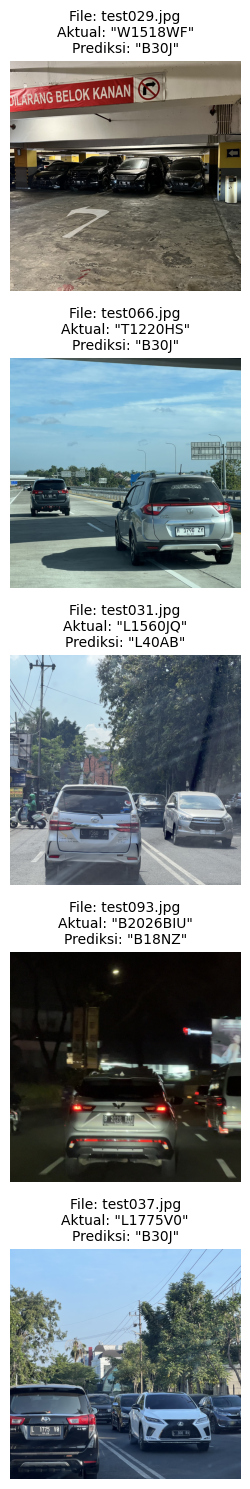

In [13]:
# 10. Inferensi dan Evaluasi pada Test Set (jika ada)
if final_test_dataset and len(final_test_dataset) > 0 and os.path.exists(OUTPUT_DIR):
    print("\nMelakukan evaluasi dan inferensi pada Test Set...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_trained = VisionEncoderDecoderModel.from_pretrained(OUTPUT_DIR)
    processor_trained = TrOCRProcessor.from_pretrained(OUTPUT_DIR)
    model_trained.to(device)

    print("Mengevaluasi CER pada test set...")
    predicted_labels_on_test = []
    actual_labels_on_test = []

    iterable_test_manual = tqdm(final_test_dataset, desc="Prediksi pada Test Set", unit="gambar")
    for encoding_item in iterable_test_manual:
        pixel_values = encoding_item["pixel_values"].unsqueeze(0).to(device)
        labels_actual_ids = encoding_item["labels"]

        with torch.no_grad():
            generated_ids = model_trained.generate(pixel_values)

        generated_text = processor_trained.batch_decode(generated_ids, skip_special_tokens=True)[0]
        predicted_labels_on_test.append(generated_text)

        # Perlu clone karena tensor labels_actual_ids akan dimodifikasi
        labels_actual_ids_for_decode = labels_actual_ids.clone()
        labels_actual_ids_for_decode[labels_actual_ids_for_decode == -100] = processor_trained.tokenizer.pad_token_id
        actual_text = processor_trained.decode(labels_actual_ids_for_decode, skip_special_tokens=True)
        actual_labels_on_test.append(actual_text)

    if predicted_labels_on_test and actual_labels_on_test:
        cer_test_final = cer_metric_evaluate.compute(predictions=predicted_labels_on_test, references=actual_labels_on_test)
        print(f"\nCharacter Error Rate (CER) pada Test Set (final): {cer_test_final}")

        # Ambil nama file dari test_image_paths yang sesuai dengan urutan final_test_dataset
        current_test_image_paths = final_test_dataset.image_paths

        df_comparison_test = pd.DataFrame({
            'file_name': [os.path.basename(p) for p in current_test_image_paths[:len(predicted_labels_on_test)]],
            'Actual Label': actual_labels_on_test,
            'Predicted Label': predicted_labels_on_test
        })
        print("\nContoh Perbandingan Hasil Prediksi pada Test Set:")
        print(df_comparison_test.head())

        comparison_csv_path_test = os.path.join(OUTPUT_DIR, "final_test_predictions_comparison.csv")
        df_comparison_test.to_csv(comparison_csv_path_test, index=False)
        print(f"Hasil perbandingan test set disimpan di: {comparison_csv_path_test}")

        num_samples_to_show = min(5, len(current_test_image_paths))
        if num_samples_to_show > 0:
            # Tentukan ukuran figure berdasarkan jumlah sampel
            fig_height = num_samples_to_show * 3 if num_samples_to_show > 1 else 4
            fig, axes = plt.subplots(num_samples_to_show, 1, figsize=(10, fig_height))
            if num_samples_to_show == 1: # Jika hanya 1 sampel, axes bukan array
                axes = [axes]

            for i in range(num_samples_to_show):
                try:
                    image_path_show = current_test_image_paths[i]
                    image_show = Image.open(image_path_show).convert("RGB")

                    ax_show = axes[i]
                    ax_show.imshow(image_show)
                    title_str = f"File: {os.path.basename(image_path_show)}\n"
                    title_str += f"Aktual: \"{actual_labels_on_test[i]}\"\n" # Gunakan dari list yang sudah dibuat
                    title_str += f"Prediksi: \"{predicted_labels_on_test[i]}\""
                    ax_show.set_title(title_str, fontsize=10)
                    ax_show.axis("off")
                except IndexError:
                    print(f"IndexError saat mencoba menampilkan gambar ke-{i}. Jumlah gambar mungkin kurang dari num_samples_to_show.")
                    break # Hentikan loop jika ada index error
                except Exception as e_plot:
                    print(f"Error plotting image {image_path_show}: {e_plot}")
            plt.tight_layout()
            plt.show()
    else:
        print("Tidak dapat menghitung CER pada test set (manual).")
else:
    print("Dataset tes kosong atau model tidak ditraining/disimpan, evaluasi akhir & inferensi pada test set dilewati.")

In [14]:
!zip -r /content/model_plat_nomor.zip /content/trocr_finetuned_plat_nomor_final_v2

  adding: content/trocr_finetuned_plat_nomor_final_v2/ (stored 0%)
  adding: content/trocr_finetuned_plat_nomor_final_v2/tokenizer_config.json (deflated 75%)
  adding: content/trocr_finetuned_plat_nomor_final_v2/config.json (deflated 64%)
  adding: content/trocr_finetuned_plat_nomor_final_v2/generation_config.json (deflated 42%)
  adding: content/trocr_finetuned_plat_nomor_final_v2/training_args.bin (deflated 52%)
  adding: content/trocr_finetuned_plat_nomor_final_v2/final_test_predictions_comparison.csv (deflated 64%)
  adding: content/trocr_finetuned_plat_nomor_final_v2/runs/ (stored 0%)
  adding: content/trocr_finetuned_plat_nomor_final_v2/runs/Jun28_17-34-52_4a19271d5dbf/ (stored 0%)
  adding: content/trocr_finetuned_plat_nomor_final_v2/runs/Jun28_17-34-52_4a19271d5dbf/events.out.tfevents.1751133637.4a19271d5dbf.510.1 (deflated 24%)
  adding: content/trocr_finetuned_plat_nomor_final_v2/runs/Jun28_17-34-52_4a19271d5dbf/events.out.tfevents.1751132097.4a19271d5dbf.510.0 (deflated 63%)

In [17]:
from google.colab import files
files.download("/content/model_plat_nomor.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>